# Task: CIFAR-10 classification

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html)

> "consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

>The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class."

<img src="http://drive.google.com/uc?export=view&id=1wlfkvZgS0oBDwxKicWmYgtsJmP3IcMdj">

# Preliminaries

In [1]:
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta, Adam, SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.regularizers import l1
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.initializers import glorot_normal

# Fix seeds for (hopefully) reproducible results
from numpy.random import seed
seed(14)
tf.random.set_seed(19)

Download the data if necessary and load it:

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize the images to the range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Split the training set into training and validation sets
from sklearn.model_selection import train_test_split
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=14)

print(train_images.shape, valid_images.shape, test_images.shape)
print(train_labels.shape, valid_labels.shape, test_labels.shape)

170498071/170498071 [==============================] - 5s 0us/step
(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 1) (10000, 1) (10000, 1)


### Categories:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

In [3]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


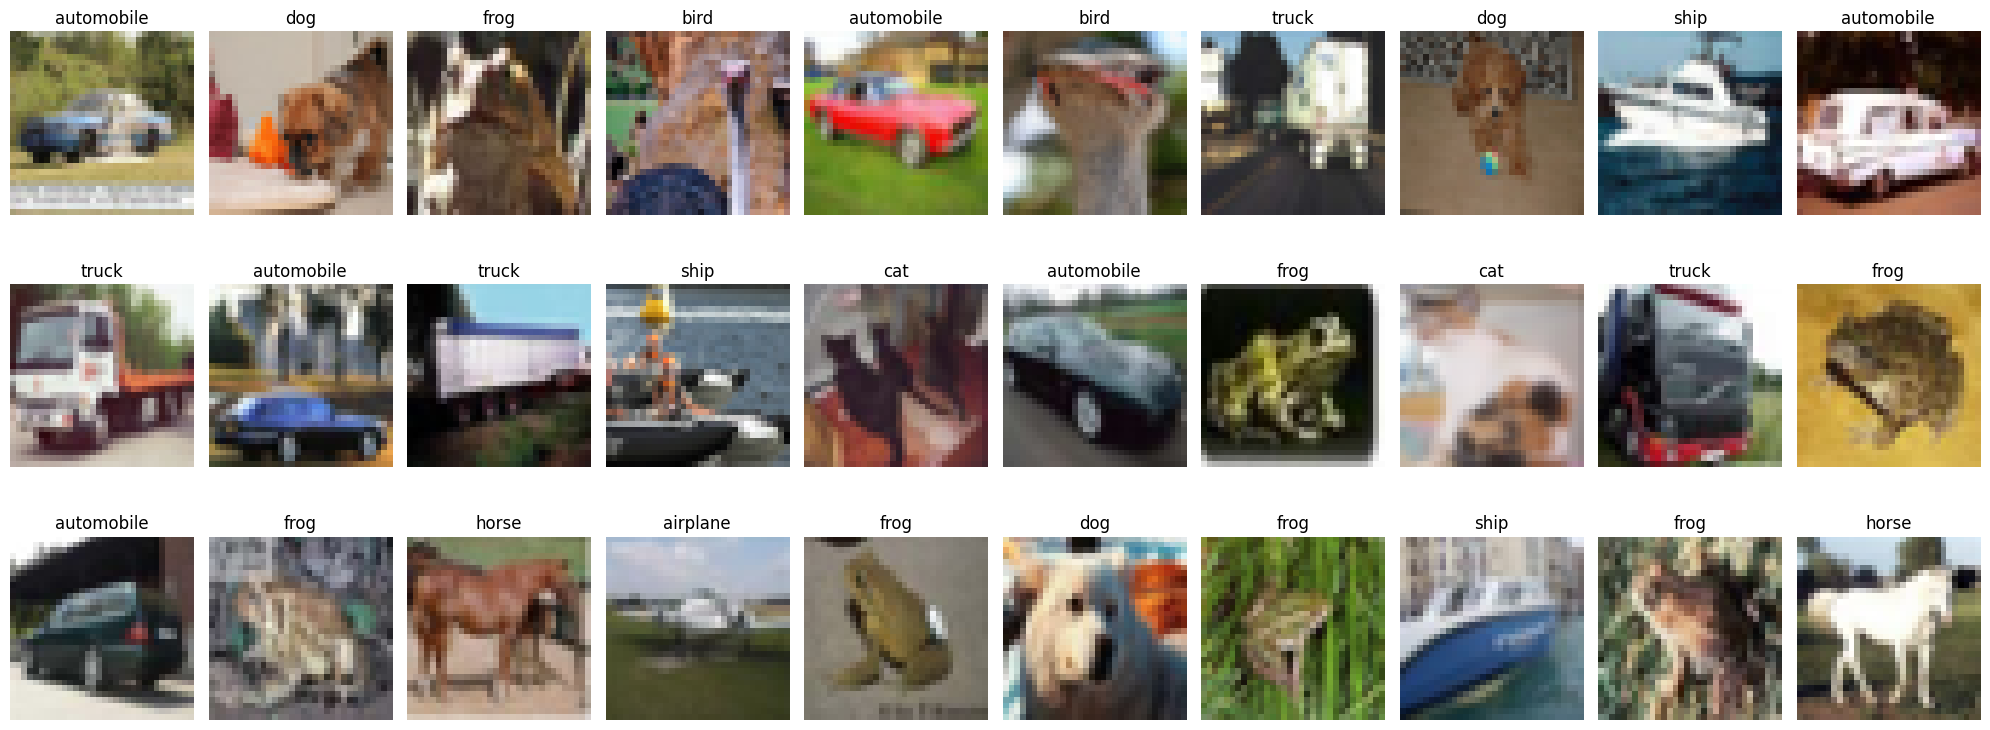

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 1) (10000, 1) (10000, 1)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
# TODO: Plot some of the images along with their labels
import matplotlib.pyplot as plt
def plot_images(images, labels, classes, nrows=3, ncols=10):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
    axes = axes.flatten()
    for img, lbl, ax in zip(images, labels, axes):
        ax.imshow(img)
        ax.set_title(classes[lbl[0]])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Select a few images and their labels to plot
num_images_to_plot = 30
sample_indices = np.random.choice(train_images.shape[0], num_images_to_plot, replace=False)
sample_images = train_images[sample_indices]
sample_labels = train_labels[sample_indices]

plot_images(sample_images, sample_labels, classes)

print(train_images.shape, valid_images.shape, test_images.shape)
print(train_labels.shape, valid_labels.shape, test_labels.shape)
print(classes)

# Model

## Parameters

In [6]:
dropout_rate_1 = 0.2  # Dropout rate for convolutional layers
dropout_rate_2 = 0.5  # Dropout rate for fully connected layers

# Batch size
batch_size = 32

# Number of epochs
epoch_count = 50

print("Dropout rate for conv layers:", dropout_rate_1)
print("Dropout rate for fully connected layers:", dropout_rate_2)
print("Batch size:", batch_size)
print("Number of epochs:", epoch_count)

print(train_images.shape, valid_images.shape, test_images.shape)
print(train_labels.shape, valid_labels.shape, test_labels.shape)
print(classes)

Dropout rate for conv layers: 0.2
Dropout rate for fully connected layers: 0.5
Batch size: 32
Number of epochs: 50
(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 1) (10000, 1) (10000, 1)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Network

## Loss, optimization and compilation

In [26]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.backend import clear_session

# Hyperparameters
dropout_rate_1 = 0.4  # Dropout rate for convolutional layers
dropout_rate_2 = 0.8  # Dropout rate for fully connected layers
batch_size = 32
epoch_count = 50

# Reset the default graph and clear the session
tf.compat.v1.reset_default_graph()
clear_session()

# Input layer: We have pictures with 32x32 pixels and 3 color channels
x = Input(shape=(32, 32, 3))

# Convolutional Layer #1: (batch_size, 32, 32, 3) -> (batch_size, 32, 32, 64)
conv1 = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)

# Pooling Layer #1: (batch_size, 32, 32, 64) -> (batch_size, 16, 16, 64)
pool1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv1)

# Define a dropout layer using the first dropout rate parameter
dropout1 = Dropout(rate=dropout_rate_1)(pool1)

# Convolutional Layer #2: (batch_size, 16, 16, 64) -> (batch_size, 16, 16, 64)
conv2 = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(dropout1)

# Pooling Layer #2: (batch_size, 16, 16, 64) -> (batch_size, 8, 8, 64)
pool2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv2)

# Define a dropout layer using the first dropout rate parameter
dropout2 = Dropout(rate=dropout_rate_1)(pool2)

# Convert tensors into vectors: (batch_size, 8, 8, 64) -> (batch_size, 4096)
pool2_flat = Flatten()(dropout2)

# Fully connected Layer #1: (batch_size, 4096) -> (batch_size, 512)
dense1 = Dense(units=512, activation='relu')(pool2_flat)

# Define a dropout layer using the second dropout rate parameter
dropout3 = Dropout(rate=dropout_rate_2)(dense1)

# Dense Layer #2: (batch_size, 512) -> (batch_size, 256)
dense2 = Dense(units=256, activation='relu')(dropout3)

# Define a dropout layer using the second dropout rate parameter
dropout4 = Dropout(rate=dropout_rate_2)(dense2)

# Logits layer: (batch_size, 256) -> (batch_size, 10)
# Define a fully connected layer with 10 nodes (one for each class) with softmax activation
predictions = Dense(units=10, activation='softmax')(dropout4)

# Full model
# Instantiate (initialize) the model with inputs and outputs
model = Model(inputs=x, outputs=predictions)

# Loss function
loss = sparse_categorical_crossentropy  # We use this cross entropy variant as the input is not one-hot encoded

# Optimizer
# Choose an optimizer - adaptive ones work well here
optimizer = Adam()

# Compilation
#############
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Print the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                        

## Training

In [27]:
history = model.fit(x=train_images, y=train_labels,
                    validation_data=(valid_images, valid_labels),
                    epochs=epoch_count,
                    batch_size=batch_size)

Epoch 1/50
1250/1250 [==============================] - 10s 7ms/step - loss: 2.2418 - accuracy: 0.1343 - val_loss: 2.0838 - val_accuracy: 0.2086
Epoch 2/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.9196 - accuracy: 0.2647 - val_loss: 1.8614 - val_accuracy: 0.3240
Epoch 3/50
1250/1250 [==============================] - 8s 6ms/step - loss: 1.7991 - accuracy: 0.3160 - val_loss: 1.6908 - val_accuracy: 0.3925
Epoch 4/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.7414 - accuracy: 0.3479 - val_loss: 1.8046 - val_accuracy: 0.3236
Epoch 5/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.7088 - accuracy: 0.3680 - val_loss: 1.6962 - val_accuracy: 0.3641
Epoch 6/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.6753 - accuracy: 0.3841 - val_loss: 1.5598 - val_accuracy: 0.4296
Epoch 7/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.6475 - accuracy: 0.3986 - val_loss: 1.6491 - val_accuracy

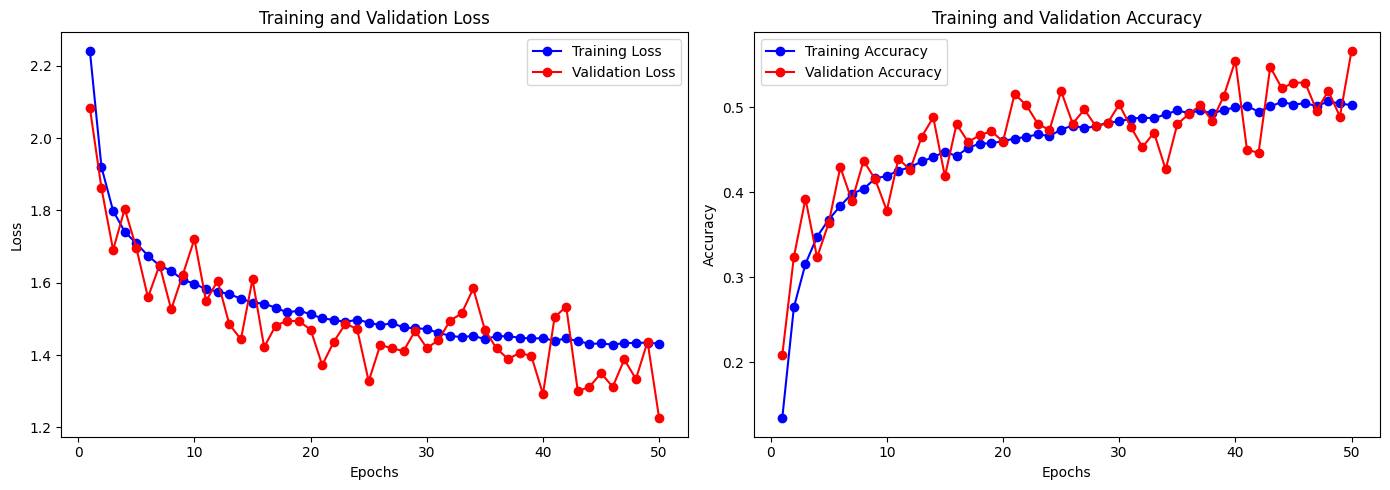

In [28]:
def plot_history(history):
    # Extract loss and accuracy values
    train_loss = history.history['loss']
    valid_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    valid_accuracy = history.history['val_accuracy']

    epochs = range(1, epoch_count + 1)

    # Plot the loss
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, valid_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, valid_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the history
plot_history(history)


In [29]:
assert max(history.history['val_accuracy']) > 0.75

AssertionError: 

## Visualization

313/313 [==============================] - 1s 2ms/step


<Figure size 3000x3000 with 0 Axes>

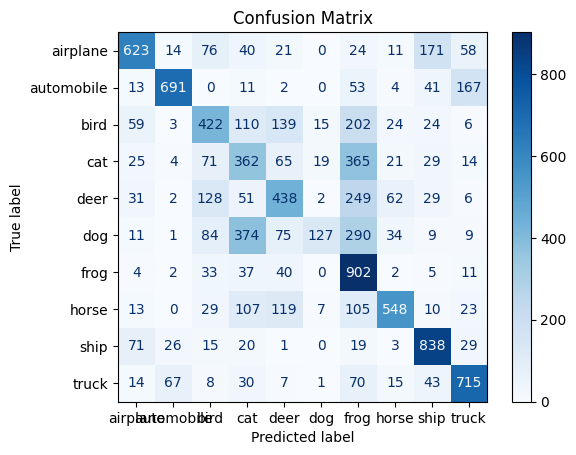

In [30]:
# TODO: Plot Confusion Matrix
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for the validation set
predicted_labels = model.predict(valid_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(valid_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [31]:
# TODO: Plot Classification Report
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Predict labels for the validation set
predicted_labels = model.predict(valid_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Generate the classification report
report = classification_report(valid_labels, predicted_labels, target_names=classes)

# Print the classification report
print(report)


313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.72      0.60      0.66      1038
  automobile       0.85      0.70      0.77       982
        bird       0.49      0.42      0.45      1004
         cat       0.32      0.37      0.34       975
        deer       0.48      0.44      0.46       998
         dog       0.74      0.13      0.21      1014
        frog       0.40      0.87      0.54      1036
       horse       0.76      0.57      0.65       961
        ship       0.70      0.82      0.75      1022
       truck       0.69      0.74      0.71       970

    accuracy                           0.57     10000
   macro avg       0.61      0.57      0.56     10000
weighted avg       0.61      0.57      0.56     10000

